In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

from warpctc_pytorch import CTCLoss

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

20_words.csv  line_labels.csv  models		  word_labels.csv  words.csv
ascii	      lines	       tmp		  words		   words.tgz
chars.csv     lines.tgz        word_char_ids.csv  words_chars.csv


In [5]:
#gpu
device = torch.device('cuda')

In [ ]:
#cpu
device = torch.device('cpu')

In [6]:
from PIL import Image

def open_image(fname):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(f'{PATH}/words/{f}')

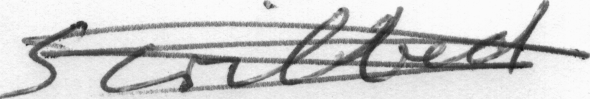

In [8]:
open_image('p06-047-08-00')

# Prelim

### DataFrame (manual)

In [43]:
# https://github.com/githubharald/SimpleHTR/blob/master/src/Model.py
    
imgSize = (128, 32)
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])

In [44]:
data = np.stack(samples)
data.shape

(115319, 2)

In [45]:
data[:,1]

array(['A', 'MOVE', 'to', ..., 'the', 'garden', '?'],
      dtype='<U32')

In [46]:
df = pd.DataFrame(data, columns=['filename', 'word'])
df.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


In [47]:
len(chars)

78

### DataFrame (read_csv)

In [10]:
word_labels = pd.read_csv(f'{PATH}/ascii/words.txt', delim_whitespace=True, comment="#", header=None, usecols=range(0, 9))

In [11]:
word_labels.columns = ['filename','result','graylevel','x','y','w','h','tag','value']

In [12]:
word_labels.tail()

,filename,result,graylevel,x,y,w,h,tag,value
75599,r06-143-04-06,ok,186,1323,1428,64,77,PP3O,him
75600,r06-143-04-07,ok,186,1458,1469,36,52,IN,in
75601,r06-143-04-08,ok,186,1532,1445,73,72,ATI,the
75602,r06-143-04-09,ok,186,1654,1444,199,114,NN,garden
75603,r06-143-04-10,ok,186,1892,1453,36,66,?,?


In [ ]:
samp = word_labels.sample(8)
info = {f'{PATH}words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

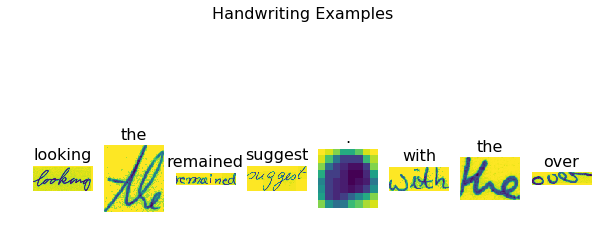

In [11]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

### check errors -> look OK

In [12]:
errors = word_labels[word_labels.result == 'err']

In [21]:
samp = errors.sample(8)
info = {f'{PATH}/words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

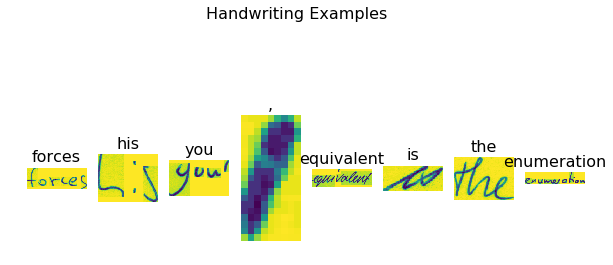

In [22]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

In [8]:
len(word_labels[word_labels.result == 'err']), len(word_labels)

(10847, 75604)

In [9]:
# remove all err results
# word_labels = word_labels[word_labels.result != 'err']
# len(word_labels)

64757

### Remove all rows where value count < 20 (word images)

In [48]:
# sort by label count
# pivot = word_labels.pivot_table(index='value', aggfunc=len).sort_values('filename', ascending=False)
pivot = df.pivot_table(index='word', aggfunc=len).sort_values('filename', ascending=False)

len(pivot)  # total num unique words

13547

In [49]:
# only keep values with counts > 20
pivot = pivot[pivot.filename > 10]
len(pivot)  # 406 unique words seen more than 20 times

1179

In [50]:
value_mask = np.array(pivot.index)
value_mask

array(['the', ',', '.', ..., 'various', 'hair', 'total'], dtype=object)

In [54]:
# apply value_mask to original csv
word_labels = word_labels[word_labels.value.isin(value_mask)]
len(word_labels)

88830

In [30]:
# apply value_mask to original csv
df = df[df.word.isin(value_mask)]
len(df)

79789

### Numericalize characters

In [55]:
itos = sorted(list(chars))
len(itos)

78

In [56]:
itos.insert(0, '_pad_')
itos.insert(1, '_unk_')

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in df.word.values])

In [57]:
len(ids)

88830

In [58]:
# convert to strings (as labels)
strs = np.array([' '.join(str(l) for l in w) for w in ids])

In [59]:
len(ids), len(df), len(strs)

(88830, 88830, 88830)

In [60]:
df['chars'] = strs
df.tail()

/Users/adamschiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,filename,word,chars
115313,r06-143-04-05,to,73 68
115314,r06-143-04-06,him,61 62 66
115315,r06-143-04-07,in,62 67
115316,r06-143-04-08,the,73 61 58
115318,r06-143-04-10,?,27


In [36]:
data = np.concatenate((data, z), axis=1)
data[:10]

array([['a01-000u-00-00', 'A', '1 29'],
       ['a01-000u-00-01', 'MOVE', '1 41 43 50 33'],
       ['a01-000u-00-02', 'to', '1 74 69'],
       ['a01-000u-00-03', 'stop', '1 73 74 69 70'],
       ['a01-000u-00-04', 'Mr.', '1 41 72 14'],
       ['a01-000u-00-05', 'Gaitskell', '1 35 55 63 74 73 65 59 66 66'],
       ['a01-000u-00-06', 'from', '1 60 72 69 67'],
       ['a01-000u-01-00', 'nominating', '1 68 69 67 63 68 55 74 63 68 61'],
       ['a01-000u-01-01', 'any', '1 55 68 79'],
       ['a01-000u-01-02', 'more', '1 67 69 72 59']],
      dtype='<U97')

In [37]:
# convert numpy array to dataframe
df = pd.DataFrame(data, columns=['filename', 'label', 'values'])
df.head()

,filename,label,values
0,a01-000u-00-00,A,1 29
1,a01-000u-00-01,MOVE,1 41 43 50 33
2,a01-000u-00-02,to,1 74 69
3,a01-000u-00-03,stop,1 73 74 69 70
4,a01-000u-00-04,Mr.,1 41 72 14


In [61]:
df.to_pickle(TMP_PATH/'words_and_chars10.pkl')

In [62]:
df = pd.read_pickle(TMP_PATH/'words_and_chars10.pkl')
df.head()

,filename,word,chars
0,a01-000u-00-00,A,28
2,a01-000u-00-02,to,73 68
3,a01-000u-00-03,stop,72 73 68 69
4,a01-000u-00-04,Mr.,40 71 13
5,a01-000u-00-05,Gaitskell,34 54 62 73 72 64 58 65 65


In [63]:
np.save(TMP_PATH/'word_ids10.npy', ids)
pickle.dump(itos, open(TMP_PATH/'word_itos10.pkl', 'wb'))

### Save to CSV

In [9]:
ids = np.load(TMP_PATH/'word_ids.npy')
itos = pickle.load(open(TMP_PATH/'word_itos.pkl', 'rb'))

In [72]:
CSV = f'{PATH}/words.csv'
CHARS = f'{PATH}/chars.csv'

In [73]:
df.to_csv(CHARS, columns=['filename', 'chars'], index=False)
# df.to_csv(CSV, columns=['filename', 'word'], index=False)

In [11]:
chars = pd.read_csv(CHARS)
chars.head()

,filename,chars
0,a01-000u-00-00,1 32
1,a01-000u-00-02,1 77 72
2,a01-000u-00-03,1 76 77 72 73
3,a01-000u-00-04,1 44 75 17
4,a01-000u-00-06,1 63 75 72 70


In [54]:
csv = pd.read_csv(CSV)
csv.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-02,to
2,a01-000u-00-03,stop
3,a01-000u-00-04,Mr.
4,a01-000u-00-06,from


### Get val_idxs

In [12]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

11968

### Preprocess (rotate, normalize)

In [13]:
f = resnet34
sz = 64
bs = 120

In [27]:
aug_tfms = [RandomRotate(3, mode=1),  # transform type Classification
            RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png')

In [28]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [29]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

### View image transforms

In [31]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    ints = np.delete(ints, 0)
    return ''.join([itos[i] for i in ints])

In [21]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

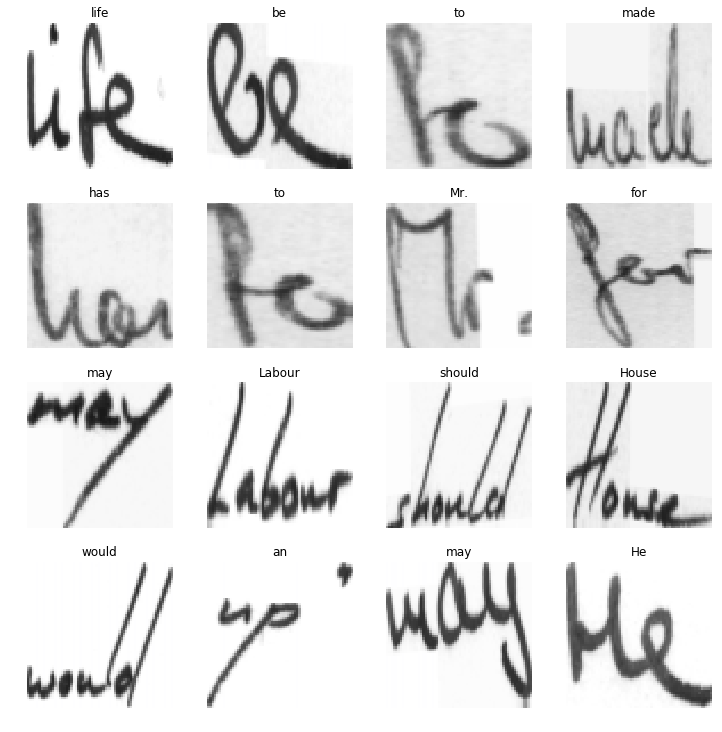

In [32]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = data.classes[y[i]]   #=>  words
#     t = label_text(y[i])     #=>  char indices
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Determine size of dataset (300,125)

In [51]:
# create a dictionary comprehension of image sizes in the dataset
size_d = {k: PIL.Image.open(PATH+k).size for k in data.val_ds.fnames}

In [52]:
row_sz,col_sz = list(zip(*size_d.values()))

In [53]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([ 2752.,  3277.,  2014.,  1023.,   406.,   168.,    49.,    18.,     4.,     3.]),
 array([   1. ,   85.1,  169.2,  253.3,  337.4,  421.5,  505.6,  589.7,  673.8,  757.9,  842. ]),
 <a list of 10 Patch objects>)

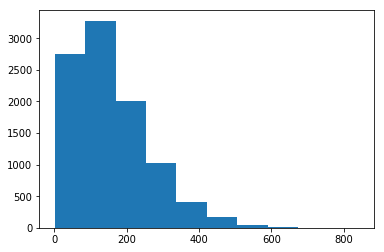

In [54]:
plt.hist(row_sz)

(array([  629.,  1338.,  2883.,  2678.,  1270.,   537.,   262.,    94.,    20.,     3.]),
 array([   1. ,   23.3,   45.6,   67.9,   90.2,  112.5,  134.8,  157.1,  179.4,  201.7,  224. ]),
 <a list of 10 Patch objects>)

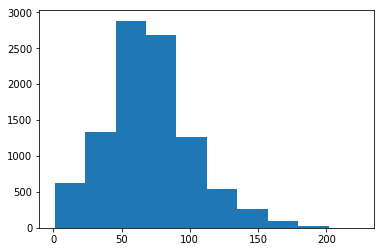

In [55]:
plt.hist(col_sz)

# CHARS

### Load csv

In [7]:
ids = np.load(TMP_PATH/'word_ids10.npy')
itos = pickle.load(open(TMP_PATH/'word_itos10.pkl', 'rb'))

In [23]:
CSV = f'{PATH}/chars.csv'

In [24]:
# df = pd.read_pickle(TMP_PATH/'words_and_chars10.pkl')
# df.head()
csv = pd.read_csv(CSV)
csv.head()

,filename,chars
0,a01-000u-00-00,28
1,a01-000u-00-02,73 68
2,a01-000u-00-03,72 73 68 69
3,a01-000u-00-04,40 71 13
4,a01-000u-00-05,34 54 62 73 72 64 58 65 65


### Get val_idxs

In [25]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

13324

### Preprocess (rotate, normalize)

In [26]:
f = resnet34
sz = 64
bs = 100 #120

In [93]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs,
                                    tfms=tfms, suffix='.png', continuous=True)

In [94]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [29]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [43]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    # ints = np.delete(ints, 0)    # only if _bos_
    return ''.join([itos[i] for i in ints])

In [44]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

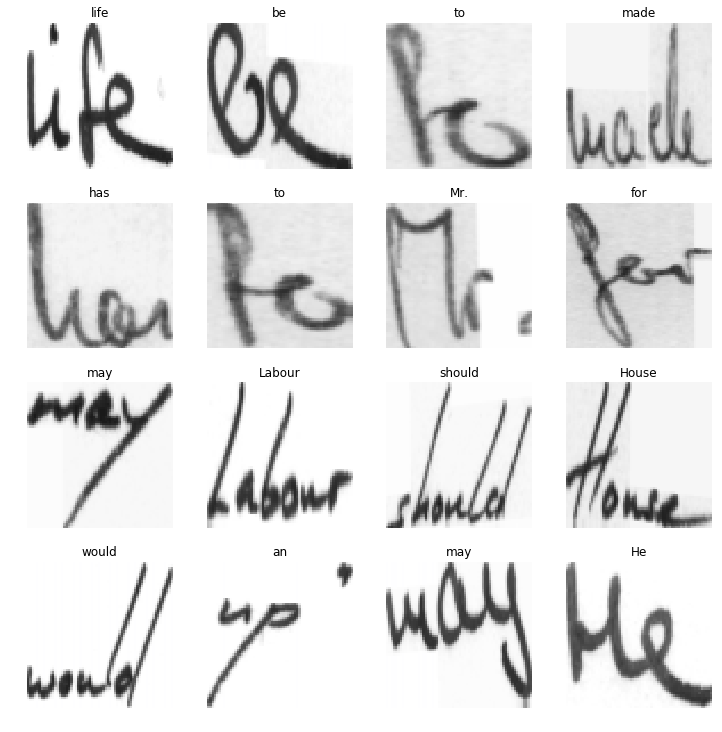

In [32]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = data.classes[y[i]]   #=>  words
#     t = label_text(y[i])     #=>  char indices
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Grayscale

In [73]:
new_x = np.mean(x[0], axis=2)
new_x.shape

(64, 64)

Text(0.5,1,'Grayscale')

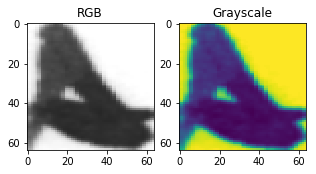

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 5))
ax1.imshow(x[0])
ax1.set_title('RGB')
ax2.imshow(new_x)
ax2.set_title('Grayscale')

## ReNet Architecture

In [30]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, p=(1,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = int(p[0])
        self.p_width = int(p[1])

        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, dropout=0, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, dropout=0, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = h / self.p_height
        new_width  = w / self.p_width

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        #x = x.permute(0, 3, 1, 2)
        x = x.contiguous()
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x

    def forward(self, inp):                
        x = self.tile(inp)                 #bs, h, w, nf
        
        x = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x


In [31]:
class ReNet(nn.Module):
    def __init__(self, nh, vs, layers=[3,10,20], p=(4,2)):
        super(ReNet, self).__init__()
        
        self.block1 = ReNetBlock(layers[0], nh, p=p)
        self.block2 = ReNetBlock(layers[1], nh, p=p)
        self.block3 = ReNetBlock(layers[2], nh, p=(4,1))
        
        self.layer1 = nn.Linear(nh*2, layers[1], bias=False)
        self.layer2 = nn.Linear(nh*2, layers[2], bias=False)
        self.layer3 = nn.Linear(nh*2, vs, bias=False)

    def forward(self, inp):
        x = inp.permute(0, 2, 3, 1) #bs, h, w, nf
        
        x = self.block1(x)          #([120, 16, 32, 200])
        x = F.relu(self.layer1(x))  #([120, 16, 32, 10])
        
        x = self.block2(x)          #([120, 4, 16, 200])
        x = F.relu(self.layer2(x))  #([120, 4, 16, 20])

        x = self.block3(x)          #([120, 1, 16, 200])
        x = F.relu(self.layer3(x))  #([120, 1, 16, 80])

        return x.squeeze(1)

In [32]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch

In [33]:
def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)
    
    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

In [34]:
net = ReNet(100, len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
# SingleModel => way to handle learning rate groups -> treats whole thing as single layer group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss
learn.clip=10.
# learn.metrics = [accuracy]

 88%|████████▊ | 666/756 [02:54<00:23,  3.82it/s, loss=5.66e+03]

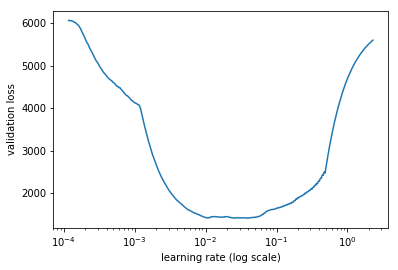

In [35]:
learn.lr_find(start_lr=1e-4)
learn.sched.plot()

In [36]:
lr = 2e-3

In [37]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      847.388857 845.898227
    1      622.37918  619.782672                           


[array([619.78267])]

In [38]:
learn.save('ReNet-CTC-2cycles-620loss')

### Results

In [70]:
denorm = data.val_ds.denorm
x,y = next(iter(data.val_dl))

In [72]:
res = predict_batch(learn.model, x)
res.shape

torch.Size([100, 16, 80])

In [74]:
preds = torch.argmax(res, dim=2)
preds

tensor([[  0,   0,   0,  ...,   0,   0,  69],
        [  0,   0,  66,  ...,   0,   0,  58],
        [  0,   0,   0,  ...,   0,   0,  73],
        ...,
        [  0,   0,   0,  ...,   0,   0,  25],
        [  0,   0,   0,  ...,   0,   0,  68],
        [  0,   0,   0,  ...,   0,  58,  58]], device='cuda:0')

In [73]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


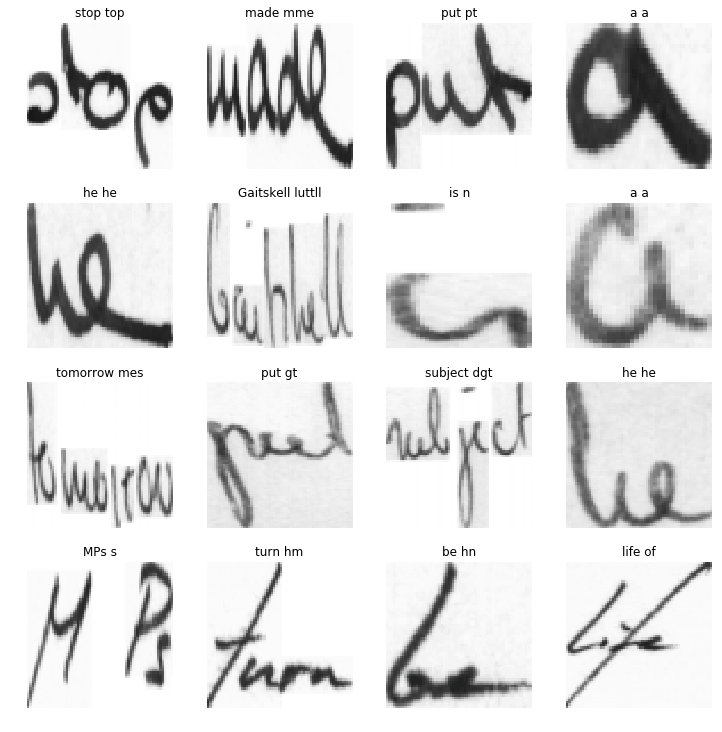

In [82]:
x = denorm(x)
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(preds[i])
    ax=show_img(x[i], ax=ax, title=t+' '+p)
    
plt.tight_layout(pad=0.1)

### Continue Training

In [38]:
learn.load('ReNet-CTC-2cycles-620loss')

In [83]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      477.723588 485.351132
    2      368.568576 384.88242                            
    3      390.540981 406.401542                           
    4      342.596647 369.97952                            
    5      314.433001 344.976688                           
    6      298.455085 339.500388                           


[array([339.50039])]

In [89]:
learn.save('ReNet-CTC-8cycles-340loss')

### Results

In [84]:
denorm = data.val_ds.denorm
x,y = next(iter(data.val_dl))

In [85]:
res = predict_batch(learn.model, x)
res.shape

torch.Size([100, 16, 80])

In [86]:
preds = torch.argmax(res, dim=2)
preds

tensor([[  0,   0,  72,  ...,   0,   0,  69],
        [  0,   0,   0,  ...,   0,  58,  58],
        [  0,   0,   0,  ...,   0,   0,  73],
        ...,
        [  0,   0,   0,  ...,   0,   0,  25],
        [  0,   0,   0,  ...,   0,   0,  68],
        [  0,   0,   0,  ...,   0,  58,  58]], device='cuda:0')

In [87]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


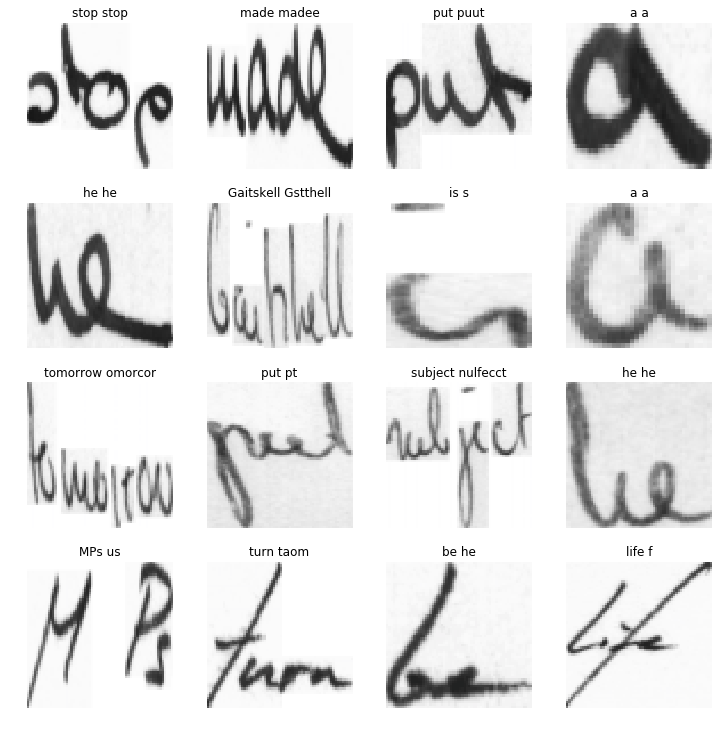

In [88]:
x = denorm(x)
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(preds[i])
    ax=show_img(x[i], ax=ax, title=t+' - '+p)
    
plt.tight_layout(pad=0.1)

### Resize to 128
need to modify architecture to handle resizing images...

In [91]:
learn.load('ReNet-CTC-8cycles-340loss')

In [92]:
sz = 128
bs = 50

In [96]:
learn.set_data(data)

In [98]:
learn.data.sz

128

In [97]:
learn.lr_find(start_lr=1e-4)
learn.sched.plot()

  0%|          | 0/1511 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 3)

## MD-LSTM

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input, hidden):
        hx, cx = hidden
        gates = F.linear(input, self.w_ih, self.b_ih) + F.linear(hx, self.w_hh, self.b_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * F.tanh(cy)

        return hy, cy

In [ ]:
class CustomMDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dimensions=2):
        super(CustomMDLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.Tensor(3 * hidden_size, input_size))
        self.b_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
        self.w_hh = nn.Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
        
        # forget gates
        self.w_ih_d1 = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_ih_d1 = nn.Parameter(torch.Tensor(hidden_size))
        self.w_hh_d1 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_hh_d1 = nn.Parameter(torch.Tensor(hidden_size))
        self.w_ih_d2 = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_ih_d2 = nn.Parameter(torch.Tensor(hidden_size))
        self.w_hh_d2 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_hh_d2 = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input, hidden_d1, hidden_d2):
        hx_d1, cx_d1 = hidden_d1
        hx_d2, cx_d2 = hidden_d2
        
        hiddens = F.linear(hx_d1, self.w_hh, self.b_hh) + F.linear(hx_d2, self.w_hh, self.b_hh)
        gates = F.linear(input, self.w_ih, self.b_ih) + hiddens
        ingate, cellgate, outgate = gates.chunk(3, 1)
        
        forget_hiddens = F.linear(hx_d1, self.w_hh_d1, self.b_hh_d1) + F.linear(hx_d2, self.w_hh_d2, self.b_hh_d2)
        forgetgate_d1 = F.sigmoid(F.linear(input, self.w_ih_d1, self.b_ih_d1) + forget_hiddens)
        forgetgate_d2 = F.sigmoid(F.linear(input, self.w_ih_d2, self.b_ih_d2) + forget_hiddens)
       
        ingate     = F.sigmoid(ingate)
        cellgate   = F.tanh(cellgate)
        outgate    = F.sigmoid(outgate)

        cy = (forgetgate_d1 * cx_d1) + (forgetgate_d2 * cx_d2) + (ingate * cellgate)
        hy = outgate * F.tanh(cy)

        return hy, cy

In [ ]:
class MDLSTM_Arch(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.CustomMDLSTM(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, x, h_vert, h_hor):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    # LSTM has a cell state in addition to a hidden state so need to return a tuple of matrices
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

### Hybrid ReNet

In [63]:
class MDGRU(nn.Module):
    def __init__(self, f, sz, nh, p=4):
        super(ReNet, self).__init__()
        self.p = p
        
        self.vrnn = nn.GRU(f*self.p**2, nh, num_layers=1,
                           bias=True, batch_first=True, dropout=0, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, dropout=0, bidirectional=True)

    def tile(self, x):
        # removed padding...
        bs, c, h, w = x.size()

        new_h = h / self.p
        new_w = w / self.p

        x = x.view(bs, c, new_h, self.p, new_w, self.p)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.contiguous()
        x = x.view(bs, new_h, new_w, self.p**2 * c)
        return x

    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, p1, p2, c = x.size()

        x = x.view(bs*p1, p2, c)   # (bs, sl, nh)  collapse non-iterated axis w/ bs
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)  # (bs, h*w, nh*2)  ([120, 256, 200])
        x = x.contiguous()
        x = x.view(bs, p1, p2, -1) # (bs, h, w, nh*2) ([120, 16, 16, 200])
        return x

    
    def forward(self,inp):        
        # convert input into tiles
        x = self.tile(inp)               #bs, h, w, nf  (bs, 16, 16, 48)
        
        x = x.permute(0, 2, 1, 3)        #b, w, h, nf
        x = x.contiguous()
        x = self.rnn_forward(x, 'ver')
        
        # swap w/h axes for hrnn
        x = x.permute(0, 2, 1, 3)        #b, h, w, nf
        x = x.contiguous()
        x = self.rnn_forward(x, 'hor')
        
        # prepare for conv layer
        x = x.permute(0, 3, 1, 2)        #b, nf, h, w
        x = x.contiguous()
        return x

In [ ]:
net = MDGRU(3,256,100)
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
# SingleModel => way to handle learning rate groups -> treats whole thing as single layer group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
learn.clip=10.
# learn.metrics = [accuracy]

## References

### seq2seq loss

In [67]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):       
    bs,sl = target.size()   #=> ([120,sl])
    sl_in,bs_in,nc = input.size()  #=> ([120, 16, 16, 200])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:20,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

### ReNet example

In [ ]:
# ReNet - https://github.com/Wizaron/reseg-pytorch/blob/master/code/pytorch/lib/arch.py

import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F

class ReNet(nn.Module):

    def __init__(self, n_input, n_units, patch_size=(1, 1), usegpu=True):
        super(ReNet, self).__init__()

        self.patch_size_height = int(patch_size[0])
        self.patch_size_width = int(patch_size[1])

        assert self.patch_size_height >= 1
        assert self.patch_size_width >= 1

        self.tiling = False if ((self.patch_size_height == 1) and (self.patch_size_width == 1)) else True

        self.rnn_hor = nn.GRU(n_input * self.patch_size_height * self.patch_size_width, n_units,
                              num_layers=1, batch_first=True, bidirectional=True)
        self.rnn_ver = nn.GRU(n_units * 2, n_units, num_layers=1, batch_first=True, bidirectional=True)

    def tile(self, x):

        n_height_padding = self.patch_size_height - x.size(2) % self.patch_size_height
        n_width_padding = self.patch_size_width - x.size(3) % self.patch_size_width

        n_top_padding = n_height_padding / 2
        n_bottom_padding = n_height_padding - n_top_padding

        n_left_padding = n_width_padding / 2
        n_right_padding = n_width_padding - n_left_padding

        x = F.pad(x, (n_left_padding, n_right_padding, n_top_padding, n_bottom_padding))

        b, n_filters, n_height, n_width = x.size()

        assert n_height % self.patch_size_height == 0
        assert n_width % self.patch_size_width == 0

        new_height = n_height / self.patch_size_height
        new_width = n_width / self.patch_size_width

        x = x.view(b, n_filters, new_height, self.patch_size_height, new_width, self.patch_size_width)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.contiguous()
        x = x.view(b, new_height, new_width, self.patch_size_height * self.patch_size_width * n_filters)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

        return x

    def rnn_forward(self, x, hor_or_ver):

        assert hor_or_ver in ['hor', 'ver']

        b, n_height, n_width, n_filters = x.size()

        x = x.view(b * n_height, n_width, n_filters)
        if hor_or_ver == 'hor':
            x, _ = self.rnn_hor(x)
        else:
            x, _ = self.rnn_ver(x)
        x = x.contiguous()
        x = x.view(b, n_height, n_width, -1)

        return x

    def forward(self, x):

                                       #b, nf, h, w
        if self.tiling:
            x = self.tile(x)           #b, nf, h, w
        x = x.permute(0, 2, 3, 1)      #b, h, w, nf
        x = x.contiguous()
        x = self.rnn_forward(x, 'hor') #b, h, w, nf
        x = x.permute(0, 2, 1, 3)      #b, w, h, nf
        x = x.contiguous()
        x = self.rnn_forward(x, 'ver') #b, w, h, nf
        x = x.permute(0, 2, 1, 3)      #b, h, w, nf
        x = x.contiguous()
        x = x.permute(0, 3, 1, 2)      #b, nf, h, w
        x = x.contiguous()

        return x

class CNN(nn.Module):

    def __init__(self, usegpu=True):
        super(CNN, self).__init__()

        self.model = models.__dict__['vgg16'](pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[0]) #TODO resnet50 :-5
        self.model = nn.Sequential(*list(self.model.children())[:16])

    def forward(self, x):

        b, n_channel, n_height, n_width = x.size()
        x = self.model(x)

        return x

class Architecture(nn.Module):

    def __init__(self, n_classes, usegpu=True):
        super(Architecture, self).__init__()

        self.n_classes = n_classes

        self.cnn = CNN(usegpu=usegpu)
        self.renet1 = ReNet(256, 100, usegpu=usegpu)
        self.renet2 = ReNet(100 * 2, 100, usegpu=usegpu)
        self.upsampling1 = nn.ConvTranspose2d(100 * 2, 50, kernel_size=(2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU()
        self.upsampling2 = nn.ConvTranspose2d(50, 50, kernel_size=(2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU()
        self.output = nn.Conv2d(50, self.n_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.cnn(x)
        x = self.renet1(x)
        x = self.renet2(x)
        x = self.relu1(self.upsampling1(x))
        x = self.relu2(self.upsampling2(x))
        x = self.output(x)
        return x

### Pytorch LSTM

In [ ]:
class LSTMCell(Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        if bias:
            self.bias_ih = Parameter(torch.Tensor(4 * hidden_size))
            self.bias_hh = Parameter(torch.Tensor(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def LSTMCell(input, hidden, w_ih, w_hh, b_ih=None, b_hh=None):
        if input.is_cuda:
            igates = F.linear(input, w_ih)
            hgates = F.linear(hidden[0], w_hh)
            state = fusedBackend.LSTMFused.apply
            return state(igates, hgates, hidden[1]) if b_ih is None else state(igates, hgates, hidden[1], b_ih, b_hh)

        hx, cx = hidden
        gates = F.linear(input, w_ih, b_ih) + F.linear(hx, w_hh, b_hh)

        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * F.tanh(cy)

        return hy, cy

    def forward(self, input, hx):
        return self.LSTMCell(
            input, hx,
            self.weight_ih, self.weight_hh,
            self.bias_ih, self.bias_hh,
        )

### Pytorch GRU

In [ ]:
class GRUCell(RNNCellBase):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(torch.Tensor(3 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        if bias:
            self.bias_ih = Parameter(torch.Tensor(3 * hidden_size))
            self.bias_hh = Parameter(torch.Tensor(3 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def GRUCell(input, hidden, w_ih, w_hh, b_ih=None, b_hh=None):

        if input.is_cuda:
            gi = F.linear(input, w_ih)
            gh = F.linear(hidden, w_hh)
            state = fusedBackend.GRUFused.apply
            return state(gi, gh, hidden) if b_ih is None else state(gi, gh, hidden, b_ih, b_hh)

        gi = F.linear(input, w_ih, b_ih)
        gh = F.linear(hidden, w_hh, b_hh)
        i_r, i_i, i_n = gi.chunk(3, 1)
        h_r, h_i, h_n = gh.chunk(3, 1)

        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + resetgate * h_n)
        hy = newgate + inputgate * (hidden - newgate)

        return hy

    def forward(self, input, hx):
        return self.GRUCell(
            input, hx,
            self.weight_ih, self.weight_hh,
            self.bias_ih, self.bias_hh,
        )

### Attention

In [35]:
# based on Show,Attend,Tell - https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))


class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=1):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 128, 20
        
        # Encoder
        self.pool = nn.AdaptiveMaxPool2d(7)      #(bs,128,7,7)
        self.linear = nn.Linear(128*7*7, em_sz)  #(6272, 256)
        self.bn = nn.BatchNorm1d(em_sz, momentum=0.01)

        # Decoder
#         self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
#         self.attn = nn.Linear(nh, nh)
#         self.gru = nn.GRU(em_sz, nh, num_layers=nl) #, dropout=0.1)
#         self.drop = nn.Dropout(0.35)
#         self.out = nn.Linear(nh, vs) #=> ([256, 80])
      
        self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl) #, dropout=0.1)
        self.drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz, vs) #=> ([256, 80])
        
        # setting up Attention Layers
        self.W1 = rand_p(nh, em_sz)  #=> ([512, 256])
        self.l2 = nn.Linear(em_sz, em_sz) 
        self.l3 = nn.Linear(em_sz+nh, em_sz) #=> ([768, 256])
        self.V = rand_p(em_sz)  #=> ([256])
  
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)        #=> ([50, 128, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)       #=> ([50, 128, 7, 7])
        feats = feats.view(feats.size(0), -1)   #(bs,6272)
        feats = self.bn(self.linear(feats))     #(bs,256)
        bs,c = feats.size()   # need this because last batch isn't 50

        h = feats.unsqueeze(0)         #(1,bs,256)
    
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        dec_inp = V(torch.zeros(bs).long()) #=> ([bs])   # initialize first word (bos token) and then replace 
        res,attns = [],[]

        # hidden state of the encoder
        w1e = h @ self.W1  #=> ([30, 125, 300])

        for i in range(self.sl):
            # take last hidden state of encoder (current hidden state of decoder) -> linear layer
            #w2h = self.l2(h[-1])  #=> ([125, 300])
            # location aware 7x7 feature map
            w2h = self.l2(torch.)
            
            # non-linear activation
            u = F.tanh(w1e + w2h + w3h + w4h) #=> ([30, 125, 300])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = F.softmax(u @ self.V, 0)  #=> ([30, 125])
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0) #=> ([125, 256])
            emb = self.emb(dec_inp) #=> ([125, 556])
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([125, 300])
            
            outp, h = self.gru(wgt_enc.unsqueeze(0), h)

#             emb = self.emb(dec_inp).unsqueeze(0)         # embedding => ([1, bs, 256])
#             outp, h = self.gru(emb, h)                   # rnn => ([1, bs, 256]),  ([1, bs, 256])
            outp = self.out(self.drop(outp[0]))          # dropout, linear layer => ([256, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])   #=> ([64])
#             if (dec_inp==1).all(): break       # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)                  # stack up list of results into single tensor and return it

    def initHidden(self):
        return V(torch.zeros(self.nl, 1, self.nh, device=device))
    
#     def initHidden(self, bs): return V(torch.zeros(self.nl, bs, em_sz))

### Show, Attend, Tell

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self):
        return cuda_variable(torch.zeros(self.num_layers, 1, self.hidden_size))

    # decoder_hidden = decoder.init_hidden()
    # outputs = decoder(captions, decoder_hidden, features, lengths)
    def forward(self, captions, last_hidden, encoder_hiddens, lengths):
        # captions: tensor of shape (batch_size, padded_length).
        # lengths: list indicating valid length for each caption. length is (batch_size).
        embeddings = self.embed(captions)
        embeddings = torch.cat((last_hidden.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        rnn_output = self.linear(hiddens[0])
        print (rnn_output)

        attn_weights = self._get_att_weight(rnn_output.squeeze(0), encoder_hiddens)
        context = attn_weights.bmm(encoder_hiddens.transpose(0,1))

        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = self.out(torch.cat((rnn_output, context), 1))

        return output

    def _get_att_weight(self, hidden, encoder_hiddens):
        seq_len = len(encoder_hiddens)

        # Create variable to store attention energies
        attn_scores = cuda_variable(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(seq_len):
            attn_scores[i] = self.get_att_score(hidden, encoder_hiddens[i])

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)


    def get_att_score(self, hidden, encoder_hidden):
        score = self.attn(encoder_hidden)
        return torch.dot(hidden.view(-1), score.view(-1))

### Pytorch tutorial - seq2seq w/ attention

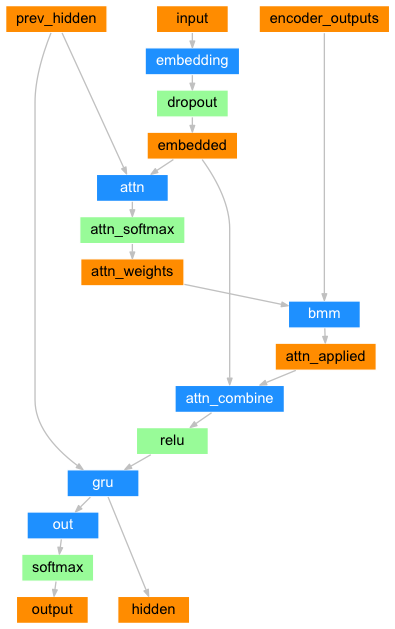

In [ ]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#attention-decoder

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # 256, ,10
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size  # 256
        self.output_size = output_size  # num words in output ~ vs
        self.dropout_p = dropout_p
        self.max_length = max_length    # 10

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # decoder_input = torch.tensor([[SOS_token]], device=device)  # BOS token
        # decoder_hidden = encoder_hidden
        # encoder_outputs = ([input_length, max_length, hidden_size])
        
        
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)              #=> ([50, 128, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)             #=> ([50, 64, 7, 7])
        out = feats.view(feats.size(0), -1)  #(bs,6272)
        out = self.bn(self.linear(out))      #(bs,256)
        bs,c = out.size()                    # need this because last batch isn't 50
        h = out.unsqueeze(0)                 #(1,bs,256)
 
        
        
        # Embed the input & apply dropout
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Concatenate embedded input & hidden -> linear layer -> softmax
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # Batch Matrix Multiply attention weights and encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Concatenate applied attention & embedded input -> linear layer -> relu
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

### From Translation notebook

In [ ]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        # setting up Attention Layers
        self.W1 = rand_p(nh, em_sz_dec)  #=> ([256, 300])
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec) 
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec) #=> ([556, 300])
        self.V = rand_p(em_sz_dec)  #=> ([300])

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)  #=> ([30, 125, 256]), ([2, 125, 256])
        # enc_out: final output of encoder layer (shape depends on input size!!)
        # h: final state of cell
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        # matrix multiply; hidden state at each time step and a random (learnable) matrix        
        w1e = enc_out @ self.W1  #=> ([30, 125, 300])
        
        for i in range(self.out_sl):
            # take last hidden state of encoder (current hidden state of decoder) -> linear layer
            w2h = self.l2(h[-1])  #=> ([125, 300])
            # non-linear activation
            u = F.tanh(w1e + w2h) #=> ([30, 125, 300])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = F.softmax(u @ self.V, 0)  #=> ([30, 125])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([30, 125, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * enc_out).sum(0) #=> ([125, 256])
            emb = self.emb_dec(dec_inp)
                                #=> ([125, 556])
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([125, 300])
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [26]:
rnn = Seq2SeqCNN_RNN(conv_model, vs, em_sz, nh, sl)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
learn.clip=10.
# learn.metrics = [accuracy]

In [ ]:
learn.lr_find(start_lr=1e-4)
learn.sched.plot()